# Data preprocessing

## Table of Contents

**Prep**
1. Load dataset
2. Simulate iris dataset with Nan

**Simple Imputations on Iris dataset** 
1. Nan check in dataframe
2. Duplicate check & immediate deletion
3. Delete features with zero or low variance
4. Option 1 - Null value deletion
5. Option 2 - Mean/Median/Mode imputation
6. Option 3 - Grouped Mean imputation
7. kNN imputation
8. Multivariate imputations are better - seeing in action
9. Multiple rounds of imputation


**Analyzing income dataset**
1. Deduplication & Nan Imputation
2. Dealing with numerical columns - Imputation & Scaling
3. Dealing with categorical variables
4. Combine all features back together - Categorical and numerical
5. Apply KNN


In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print(f"numpy version = {np.__version__}")
print(f"pandas version = {pd.__version__}") 
print(f"sklearn version = {sk.__version__}")

numpy version = 1.24.3
pandas version = 1.5.3
sklearn version = 1.3.0


### Load dataset

In [3]:
# import load_iris function from datasets module
from sklearn.datasets import load_iris

def get_iris_df(concatenate_Xy=False):
    iris = load_iris()

    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    y = iris.target

    print(f"Creating Iris dataframe with {df.shape} records and {y.shape} target records")

    if concatenate_Xy is True:
        df["target"] = y
        return df

    return df, y

In [4]:
df, y = get_iris_df()

Creating Iris dataframe with (150, 4) records and (150,) target records


### Simulate a dataset with Nan

Setting random sepal length & width to be Nan

In [6]:
# Generate some random index. We will set sepal length in those rows to be Nan
sepal_len_nan_row_idx = np.random.randint(low=0, high=df.shape[0], size=10)
sepal_len_nan_row_idx

array([ 65,  64,  37,  75, 118,  49,  74, 109,  43,  66])

In [7]:
# Set selected sepal length to be Nan
df.iloc[sepal_len_nan_row_idx.tolist(),0] = np.nan

In [8]:
# Check Nan
# Question: Why this does not work? Have we not set the nan already
df[df["sepal length (cm)"] == np.nan] 

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)


In [9]:
# Let us check the Nan in a different way
df.iloc[sepal_len_nan_row_idx.tolist()] #Indeed they are set to nan

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
65,NaN,3.1,4.4,1.4
64,NaN,2.9,3.6,1.3
37,NaN,3.6,1.4,0.1
75,NaN,3.0,4.4,1.4
118,NaN,2.6,6.9,2.3
49,NaN,3.3,1.4,0.2
74,NaN,2.9,4.3,1.3
109,NaN,3.6,6.1,2.5
43,NaN,3.5,1.6,0.6
66,NaN,3.0,4.5,1.5


In [10]:
# Correct way of checking for nan

df[df["sepal length (cm)"].isnull()] #isnull and isna are equal. both work

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
37,NaN,3.6,1.4,0.1
43,NaN,3.5,1.6,0.6
49,NaN,3.3,1.4,0.2
64,NaN,2.9,3.6,1.3
65,NaN,3.1,4.4,1.4
66,NaN,3.0,4.5,1.5
74,NaN,2.9,4.3,1.3
75,NaN,3.0,4.4,1.4
109,NaN,3.6,6.1,2.5
118,NaN,2.6,6.9,2.3


Set some sepal width also to be Nan

In [11]:
sepal_wid_nan_row_idx = np.random.randint(low=0, high=df.shape[0], size=10)
df.iloc[sepal_wid_nan_row_idx.tolist(),1] = np.nan
df[df["sepal width (cm)"].isnull()] #isnull and isna are equal. both work

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
18,5.7,NaN,1.7,0.3
29,4.7,NaN,1.6,0.2
42,4.4,NaN,1.3,0.2
55,5.7,NaN,4.5,1.3
56,6.3,NaN,4.7,1.6
64,NaN,NaN,3.6,1.3
97,6.2,NaN,4.3,1.3
127,6.1,NaN,4.9,1.8
141,6.9,NaN,5.1,2.3
149,5.9,NaN,5.1,1.8


<hr/>

## Basic EDA

### 1. Nan check in dataframe

In [12]:
# Additional arguments do display all columns even when column count is large
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  140 non-null    float64
 1   sepal width (cm)   140 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [13]:
df.isna().any(axis=0) # Columns that have ALL non null values show as false

sepal length (cm)     True
sepal width (cm)      True
petal length (cm)    False
petal width (cm)     False
dtype: bool

In [14]:
# returns Series with True for rows that contain AT LEAST ONE na in columns
df.isna().any(axis=1)

0      False
1      False
2      False
3      False
4      False
       ...  
145    False
146    False
147    False
148    False
149     True
Length: 150, dtype: bool

In [15]:
df.isna().sum() # Check null count in each column

sepal length (cm)    10
sepal width (cm)     10
petal length (cm)     0
petal width (cm)      0
dtype: int64

In [16]:
df.isna().any(axis=1).sum() #Total number of rows with Nan in any of four columns

19

### 2. Duplicate check & immediate deletion

In [17]:
# returns a series with True False for every row
dupsSeries = df.duplicated() 
print(f"Number of duplicates = {dupsSeries.sum()}")

Number of duplicates = 1


In [18]:
df.drop_duplicates(inplace=True)
df.info() # check again to confirm duplicates gone

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  139 non-null    float64
 1   sepal width (cm)   139 non-null    float64
 2   petal length (cm)  149 non-null    float64
 3   petal width (cm)   149 non-null    float64
dtypes: float64(4)
memory usage: 5.8 KB


### 3. Delete features with zero or low variance

A quasi-constant feature, using a threshold of 0.1 means 90% of the values are similar

In [19]:
from sklearn.feature_selection import VarianceThreshold

var_thr = VarianceThreshold(threshold = 0.25) #Removing both constant and quasi-constant
var_thr.fit(df)

var_thr.get_support() # we are not deleting here. we just want to get an idea

#also the threshold is generally less than 0.1

array([ True, False,  True,  True])

### 4. Option 1 - Null value deletion

In [20]:
# Reload the iris dataframe and set null values as before
df, y = get_iris_df()
df.iloc[sepal_len_nan_row_idx.tolist(),0] = np.nan
df.iloc[sepal_wid_nan_row_idx.tolist(),1] = np.nan

Creating Iris dataframe with (150, 4) records and (150,) target records


In [21]:
df[
    df["sepal length (cm)"].isnull() | 
    df["sepal width (cm)"].isnull()
]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
18,5.7,NaN,1.7,0.3
29,4.7,NaN,1.6,0.2
37,NaN,3.6,1.4,0.1
42,4.4,NaN,1.3,0.2
43,NaN,3.5,1.6,0.6
49,NaN,3.3,1.4,0.2
55,5.7,NaN,4.5,1.3
56,6.3,NaN,4.7,1.6
64,NaN,NaN,3.6,1.3
65,NaN,3.1,4.4,1.4


Drop rows containing null value

In [22]:
# conditionally dropping records
df = df.drop(
        df[
            df["sepal length (cm)"].isnull() | 
            df["sepal width (cm)"].isnull()
        ].index)
df.shape

(131, 4)

In [192]:
# The following is equivalent to drop all na rows in place
#df.dropna(how = 'any', inplace = True )

### 5. Option 2 - Mean/Median/Mode imputation

In [23]:
# Reload the iris dataframe and set null values as before
df, y = get_iris_df()
df.iloc[sepal_len_nan_row_idx.tolist(),0] = np.nan
df.iloc[sepal_wid_nan_row_idx.tolist(),1] = np.nan
df[
    df["sepal length (cm)"].isnull() | 
    df["sepal width (cm)"].isnull()
]

Creating Iris dataframe with (150, 4) records and (150,) target records


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
18,5.7,NaN,1.7,0.3
29,4.7,NaN,1.6,0.2
37,NaN,3.6,1.4,0.1
42,4.4,NaN,1.3,0.2
43,NaN,3.5,1.6,0.6
49,NaN,3.3,1.4,0.2
55,5.7,NaN,4.5,1.3
56,6.3,NaN,4.7,1.6
64,NaN,NaN,3.6,1.3
65,NaN,3.1,4.4,1.4


In [194]:
# Mean imputation directly from Pandas should also work
# df['sepal length (cm)'] = df['sepal length (cm)'].fillna(df['sepal length (cm)'].mean())

Mean imputation for numeric values

In [24]:
df.mean() #Find mean of each column in dataframe

sepal length (cm)    5.827143
sepal width (cm)     3.052857
petal length (cm)    3.758000
petal width (cm)     1.199333
dtype: float64

In [25]:
from sklearn.impute import SimpleImputer

# we can use mean median or mode for imputation
imputer = SimpleImputer(missing_values=np.nan, strategy="mean") 
imputer.fit_transform(df) #did you notice the output is no longer dataframe? It is a numpy array

array([[5.1       , 3.5       , 1.4       , 0.2       ],
       [4.9       , 3.        , 1.4       , 0.2       ],
       [4.7       , 3.2       , 1.3       , 0.2       ],
       [4.6       , 3.1       , 1.5       , 0.2       ],
       [5.        , 3.6       , 1.4       , 0.2       ],
       [5.4       , 3.9       , 1.7       , 0.4       ],
       [4.6       , 3.4       , 1.4       , 0.3       ],
       [5.        , 3.4       , 1.5       , 0.2       ],
       [4.4       , 2.9       , 1.4       , 0.2       ],
       [4.9       , 3.1       , 1.5       , 0.1       ],
       [5.4       , 3.7       , 1.5       , 0.2       ],
       [4.8       , 3.4       , 1.6       , 0.2       ],
       [4.8       , 3.        , 1.4       , 0.1       ],
       [4.3       , 3.        , 1.1       , 0.1       ],
       [5.8       , 4.        , 1.2       , 0.2       ],
       [5.7       , 4.4       , 1.5       , 0.4       ],
       [5.4       , 3.9       , 1.3       , 0.4       ],
       [5.1       , 3.5       ,

If the previous cell imputed data, why are there still Nans in dataframe?
Ans: Because imputation transforms are not in-place

In [26]:
df[
    df["sepal length (cm)"].isnull() | 
    df["sepal width (cm)"].isnull()
]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
18,5.7,NaN,1.7,0.3
29,4.7,NaN,1.6,0.2
37,NaN,3.6,1.4,0.1
42,4.4,NaN,1.3,0.2
43,NaN,3.5,1.6,0.6
49,NaN,3.3,1.4,0.2
55,5.7,NaN,4.5,1.3
56,6.3,NaN,4.7,1.6
64,NaN,NaN,3.6,1.3
65,NaN,3.1,4.4,1.4


In [27]:
imputer = SimpleImputer(missing_values=np.nan, strategy="mean") 
X_imputed = imputer.fit_transform(df)
X_imputed[0:5,:]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

1. How to know which row/col is imputed?
2. Why do we want to know which row/col is imputed 

In [28]:
imputer = SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=True) 
X_imputed = imputer.fit_transform(df)
X_imputed[0:5]

array([[5.1, 3.5, 1.4, 0.2, 0. , 0. ],
       [4.9, 3. , 1.4, 0.2, 0. , 0. ],
       [4.7, 3.2, 1.3, 0.2, 0. , 0. ],
       [4.6, 3.1, 1.5, 0.2, 0. , 0. ],
       [5. , 3.6, 1.4, 0.2, 0. , 0. ]])

In [200]:
# X_imputed[
#     X_imputed[:,4] == 1 or X_imputed[:,5] == 1
# ]

https://stackoverflow.com/questions/10062954/valueerror-the-truth-value-of-an-array-with-more-than-one-element-is-ambiguous

In [29]:
# This is a True false 1D array
X_imputed[:,4] == 1 

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,

Does it make sense now why numpy wants clarity on what you plan to perform with OR between two True/False arrays

In [30]:
np.logical_or(X_imputed[:,4] == 1, X_imputed[:,5] == 1)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True, False, False, False, False,  True,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True,

In [31]:
np.any([X_imputed[:,4] == 1, X_imputed[:,5] == 1], axis=0)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True, False, False, False, False,  True,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True,

In [32]:
# we will use logical or
X_imputed[
    np.logical_or(X_imputed[:,4] == 1, X_imputed[:,5] == 1)
]

array([[5.7       , 3.05285714, 1.7       , 0.3       , 0.        ,
        1.        ],
       [4.7       , 3.05285714, 1.6       , 0.2       , 0.        ,
        1.        ],
       [5.82714286, 3.6       , 1.4       , 0.1       , 1.        ,
        0.        ],
       [4.4       , 3.05285714, 1.3       , 0.2       , 0.        ,
        1.        ],
       [5.82714286, 3.5       , 1.6       , 0.6       , 1.        ,
        0.        ],
       [5.82714286, 3.3       , 1.4       , 0.2       , 1.        ,
        0.        ],
       [5.7       , 3.05285714, 4.5       , 1.3       , 0.        ,
        1.        ],
       [6.3       , 3.05285714, 4.7       , 1.6       , 0.        ,
        1.        ],
       [5.82714286, 3.05285714, 3.6       , 1.3       , 1.        ,
        1.        ],
       [5.82714286, 3.1       , 4.4       , 1.4       , 1.        ,
        0.        ],
       [5.82714286, 3.        , 4.5       , 1.5       , 1.        ,
        0.        ],
       [5.82714286, 2

### 6. Option 3 - Grouped Mean imputation

In [33]:
# Reload the iris dataframe and set null values as before
df = get_iris_df(concatenate_Xy=True) #Note that now, we are including both X and y in df
df.iloc[sepal_len_nan_row_idx.tolist(),0] = np.nan
df.iloc[sepal_wid_nan_row_idx.tolist(),1] = np.nan

Creating Iris dataframe with (150, 4) records and (150,) target records


In [34]:
df.mean()

sepal length (cm)    5.827143
sepal width (cm)     3.052857
petal length (cm)    3.758000
petal width (cm)     1.199333
target               1.000000
dtype: float64

In [35]:
grp = df.groupby("target")
grp.get_group(0).mean()

sepal length (cm)    5.008511
sepal width (cm)     3.429787
petal length (cm)    1.462000
petal width (cm)     0.246000
target               0.000000
dtype: float64

In [36]:
grp.get_group(1).mean()

sepal length (cm)    5.908889
sepal width (cm)     2.752174
petal length (cm)    4.260000
petal width (cm)     1.326000
target               1.000000
dtype: float64

In [37]:
grp.get_group(2).mean()

sepal length (cm)    6.552083
sepal width (cm)     2.970213
petal length (cm)    5.552000
petal width (cm)     2.026000
target               2.000000
dtype: float64

In [38]:
df["sepal length (cm)"].isna()

0      False
1      False
2      False
3      False
4      False
       ...  
145    False
146    False
147    False
148    False
149    False
Name: sepal length (cm), Length: 150, dtype: bool

In [39]:
df["sepal_length_nan_indicator"] = df["sepal length (cm)"].isna()

In [40]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,sepal_length_nan_indicator
0,5.1,3.5,1.4,0.2,0,False
1,4.9,3.0,1.4,0.2,0,False
2,4.7,3.2,1.3,0.2,0,False
3,4.6,3.1,1.5,0.2,0,False
4,5.0,3.6,1.4,0.2,0,False
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,False
146,6.3,2.5,5.0,1.9,2,False
147,6.5,3.0,5.2,2.0,2,False
148,6.2,3.4,5.4,2.3,2,False


In [41]:
df["sepal_length_nan_indicator"] = df["sepal length (cm)"].isna().astype(int)

In [42]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,sepal_length_nan_indicator
0,5.1,3.5,1.4,0.2,0,0
1,4.9,3.0,1.4,0.2,0,0
2,4.7,3.2,1.3,0.2,0,0
3,4.6,3.1,1.5,0.2,0,0
4,5.0,3.6,1.4,0.2,0,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,0
146,6.3,2.5,5.0,1.9,2,0
147,6.5,3.0,5.2,2.0,2,0
148,6.2,3.4,5.4,2.3,2,0


In [43]:
df["sepal_width_nan_indicator"] = df["sepal width (cm)"].isna().astype(int)

In [44]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,sepal_length_nan_indicator,sepal_width_nan_indicator
0,5.1,3.5,1.4,0.2,0,0,0
1,4.9,3.0,1.4,0.2,0,0,0
2,4.7,3.2,1.3,0.2,0,0,0
3,4.6,3.1,1.5,0.2,0,0,0
4,5.0,3.6,1.4,0.2,0,0,0
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,0,0
146,6.3,2.5,5.0,1.9,2,0,0
147,6.5,3.0,5.2,2.0,2,0,0
148,6.2,3.4,5.4,2.3,2,0,0


In [45]:
df['sepal length (cm)'] = \
    df.groupby(['target'], sort=False)['sepal length (cm)'].apply(lambda x: x.fillna(x.mean()))

df['sepal width (cm)'] = \
    df.groupby(['target'], sort=False)['sepal width (cm)'].apply(lambda x: x.fillna(x.mean()))

C:\Users\appur\AppData\Local\Temp\ipykernel_26524\1190462653.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df.groupby(['target'], sort=False)['sepal length (cm)'].apply(lambda x: x.fillna(x.mean()))
C:\Users\appur\AppData\Local\Temp\ipykernel_26524\1190462653.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..

In [46]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,sepal_length_nan_indicator,sepal_width_nan_indicator
0,5.1,3.500000,1.4,0.2,0,0,0
1,4.9,3.000000,1.4,0.2,0,0,0
2,4.7,3.200000,1.3,0.2,0,0,0
3,4.6,3.100000,1.5,0.2,0,0,0
4,5.0,3.600000,1.4,0.2,0,0,0
...,...,...,...,...,...,...,...
145,6.7,3.000000,5.2,2.3,2,0,0
146,6.3,2.500000,5.0,1.9,2,0,0
147,6.5,3.000000,5.2,2.0,2,0,0
148,6.2,3.400000,5.4,2.3,2,0,0


### 7. Knn Imputation

In [47]:
# Reload the iris dataframe and set null values as before
df = get_iris_df(concatenate_Xy=True) #Note that now, we are NOT including y because KnnImputer will use y in distance calc
df.iloc[sepal_len_nan_row_idx.tolist(),0] = np.nan
df.iloc[sepal_wid_nan_row_idx.tolist(),1] = np.nan

Creating Iris dataframe with (150, 4) records and (150,) target records


In [48]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2, weights='uniform', metric='nan_euclidean')
X_imputed = imputer.fit_transform(df)
X_imputed[0:5]

array([[5.1, 3.5, 1.4, 0.2, 0. ],
       [4.9, 3. , 1.4, 0.2, 0. ],
       [4.7, 3.2, 1.3, 0.2, 0. ],
       [4.6, 3.1, 1.5, 0.2, 0. ],
       [5. , 3.6, 1.4, 0.2, 0. ]])

### 8. Multivariate imputations are better - seeing in action

In [49]:
df_dummy = pd.DataFrame()
df_dummy["Age"] = [np.nan, 35, 45, 25, 55, 40, 30]
df_dummy["MonthlySal_InLakhs"] = [1, 3, 5, 1.2, 6.5, 4, 2.7]
df_dummy

,Age,MonthlySal_InLakhs
0,NaN,1.0
1,35.0,3.0
2,45.0,5.0
3,25.0,1.2
4,55.0,6.5
5,40.0,4.0
6,30.0,2.7


In [50]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
mean_imputed = imputer.fit_transform(df_dummy)
df_mean_imputed = pd.DataFrame(mean_imputed, columns=["Age", "MonthlySal_InLakhs"])

In [51]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer()
iter_imputed = imputer.fit_transform(df_dummy)
df_iter_imputed = pd.DataFrame(iter_imputed, columns=["Age", "MonthlySal_InLakhs"])

0.976
0.196


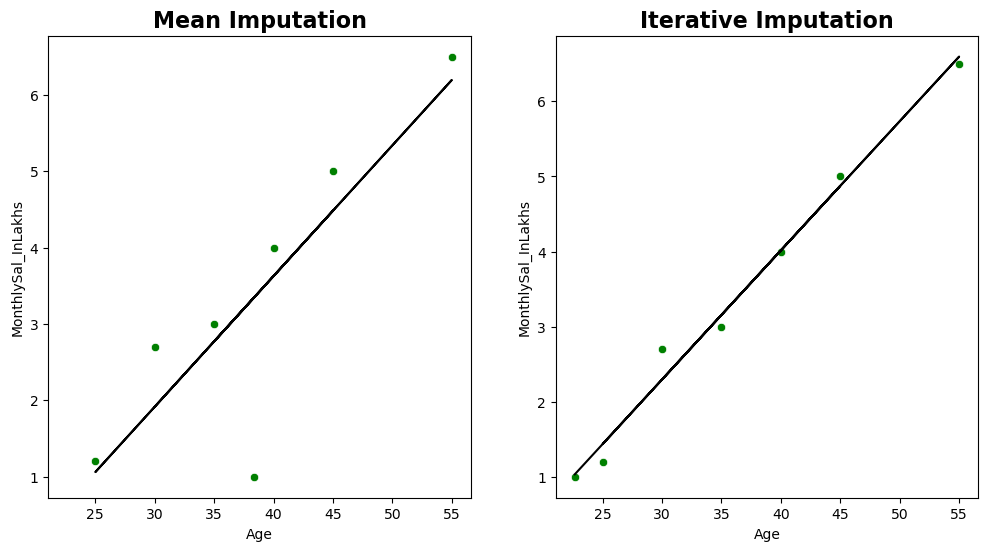

In [52]:
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12, 6))
axes = np.reshape(axes, -1)

dfs = [df_mean_imputed, df_iter_imputed]
titles = ['Mean Imputation', 'Iterative Imputation']

for i, df in enumerate(dfs):
    # Plotting the data
    x = df.Age
    y = df.MonthlySal_InLakhs

    sns.scatterplot(df, x="Age", y="MonthlySal_InLakhs", ax=axes[i], color='green')
    
    # Fitting and plotting a linear regression line
    m, b = np.polyfit(x, y, 1)
    linreg = m*x + b
    axes[i].plot(x, linreg, color='black')
    
    # # Setting the titles and including the RMSE values
    axes[i].set_title(titles[i], fontsize=16, fontweight='bold')
    rmse = round(mean_squared_error(y, linreg, squared=False), 3)
    print((rmse))

plt.show()

### 9. Multiple rounds of imputation

This refers to the chicken and egg problem we talked in the class

1. First we could do a mean imputation (or grouped mean imputation) by also using missing_indicator= true
2. This flag ensures that a new feature is added that holds 0/1 values. 1 for rows whose Nan was imputed by mean. 0 otherwise
3. With the nasty nans out of the way, apply scaling
4. Now we could go back and run a pandas update (apply or other means) to replace all those rows with Nan again for which missing indicator feature is 1.
5. Then throw away the missing indicator feature
6. Apply a multivariate imputation like knn imputation for the Nans themselves

<hr/>

## Analyzing income dataset

### 1. Deduplication & Nan Imputation 

In [54]:
df = pd.read_csv("income.csv")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [56]:
df.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

Is there no Nans?

In [ ]:
# TODO: What will you check in csv for Nan? 
df.isin([?]).sum()

In [57]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

Fix the code below

In [ ]:
# TODO: Fix the code below
df.workclass = df['workclass'].replace(?, np.nan)
df.occupation = df.occupation.replace(?, np.nan)
df['native-country'] = df[?].replace(?, ?) 

In [ ]:
df.isna().sum()

In [ ]:
# Visual pleasure for your eyes only 
sns.heatmap(df.isnull());

In [ ]:
nan_percent  = (df.isna().sum() * 100 / len(df)).round(2)
nan_percent

In [ ]:
df[df.duplicated()]

In [ ]:
print(f"There are {df.duplicated().sum()} duplicated values present.")
df[df.duplicated()].shape

In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
df[df.duplicated()]

### 2. Checking for numerical columns - Imputation & Scaling

In [ ]:
#Select numeric columns

numeric_cols = df.select_dtypes(include=['int', 'float']).columns.tolist()
print(numeric_cols)

In [ ]:
# describe stats can run only on numerical column. meaningless for others
df[numeric_cols].describe() 

In [ ]:
df["educational-num"].unique() #this is really a numerical looking ordinal field

In [ ]:
df2 = df[numeric_cols].loc[:, df[numeric_cols].columns != "educational-num"]
df2.head()

**Apply Standard Scaler on numerical columns**

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_numeric_scaled = sc.fit_transform(df2)
X_numeric_scaled[0:5]

##### Exercise

1. Add code for imputing numerical columns if any

In [ ]:
# What will you pass as input? df2 or X_numeric_scaled?

### 3. Dealing with categorical variables

In [ ]:
df.dtypes

In [ ]:
df.nunique() # if the column listed takes on a fixed set of values then it is encoding candidate

In [ ]:
df.workclass.unique()

In [ ]:
df["workclass"].value_counts() # do for every candidate column & decide label, ordinal or one hot encoder

In [ ]:
#df.education.unique()
#df['marital-status'].value_counts()
#df.occupation.value_counts()

##### 3.1 Impute Categorical column with most frequent

In [ ]:
# Question: Why does this fail?

imputer = SimpleImputer(strategy="most_frequent")
workclass_imputed = imputer.fit_transform(df["workclass"])
workclass_imputed[0:5]

In [ ]:
# TODO: Fix the code below for the error you see 
imputer = SimpleImputer(strategy="most_frequent")
workclass_imputed = imputer.fit_transform(df["workclass"]) #Fix this line of code 
workclass_imputed[0:5]

In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns
df_categorical = df[categorical_columns]
df_categorical.head()

In [ ]:
categorical_imputed = imputer.fit_transform(df_categorical)
categorical_imputed[0:5]

And we forgot to add educational-num to categorical dataframe

In [ ]:
imputer = SimpleImputer(strategy="most_frequent")
edu_num_imputed = imputer.fit_transform(df["educational-num"].to_numpy().reshape(-1,1))
edu_num_imputed[0:5]

##### 3.2 Combine the categorical columns together

before we stack all together, we should separate the income field in categorical. It is the target variable 

In [ ]:
imputed_categorical_features = categorical_imputed[:,:-1]

target_var = categorical_imputed[:,-1:]

In [ ]:
X_categorical = np.hstack((edu_num_imputed, imputed_categorical_features))
X_categorical[0:5]

##### 3.3 Apply One Hot encoding 

In [ ]:
X_onehot = np.hstack( (X_categorical[:,:6], X_categorical[:,-1:]) )
X_onehot[0:5]

##### 3.4 Apply Label encoding

In [ ]:
# Gender and race columns are to be label encoded
X_label = X_categorical[:,-3:-1]
X_label[0:5]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

..
..
??

##### 3.5 Apply Ordinal Encoder to institutional-num

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

..
..
??

##### 3.6 What about the target income? Is it Label or ordinal?

### 4. Combine all features back together - Categorical and numerical

Rememeber the order 

### 5. Apply KNN 

In [ ]:
# TODO: Do train and test split and do fit and predict  

**What about train test split? What about fit_transform() and transform()? ... Oops**

BIGGEST MISTAKE